**Note on the imported packages.** At some point, we will use Naima here, and if I understand correctly, it requires Numpy v. < 2. But I had Numpy of the version 2...! So you can either downgrade Numpy to <2, or (what my best friend ChatGPT said to do) create an environment with Numpy < 2 and Naima installed (and some other packages which do not seem to be in conflict with Numpy or Naima). If you follow the second way, ensure that this Notebook is launched from the right environment. 

In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen


In [2]:
from ibsen.orbit import Orbit

DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name)


In [3]:
from ibsen.winds import Winds
winds = Winds(orbit=orb, sys_name = sys_name, alpha=10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, ns_b_apex=2)



In [6]:
from ibsen.ibs import IBS
from ibsen.el_ev import ElectronsOnIBS
from scipy.integrate import trapezoid

t = -5 * DAY
Nibs = 41
ibs = IBS(winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          t_to_calculate_beta_eff=t) # the same IBS as before

els = ElectronsOnIBS(ibs=ibs, 
                     cooling='adv', 
                     ecut = 5.e12, 
                     p_e = 1.8, 
                     eta_a = 2, 
                     ) 

els.calculate(to_return=False)
print('done')

done


Now it's close to finish: let's calculate the spectrum of the IBS. We know its shape, we know everything about electrons emitting, so we can calculate the Synchrotron and inverse Compton emission. This is done using \texttt{Naima} code, so you should have it installed. 
There are three modes of calculation : `method=apex`, `method=simple`, and `method=full`.
 - `method=apex`: calculate the SED using the $B/u$ values in the IBS apex and a total e-spectrum,
 - `method=simple`: calculate SED with some effective values of $B/u$ and rescale it in a simplified manner for all segments on the IBS. I am currently using the following: first, I find the power-law indexes for the electron population for energies relevant for the synchrotron emission around 3 keV and for IC around 1 TeV. I call these indexes $p_b$ and $p_u$. After that, the effective values of the magnetic field, photon field energy, effective temperature, and scattering angle are calculated as
   $$Q_\mathrm{eff}^p \sum_\mathrm{IBS} \delta_\mathrm{doppl}^{p_\delta}= 
   \sum_\mathrm{IBS}Q_i^p  \delta_\mathrm{doppl}^{p_\delta}$$,
   where $p = (p_b+1)/2$ for the magnetic field and $p = (p_u+1)/2$ for everything else. See further for $p_\delta$. After syn+IC SED is calculated using these effective values and the total electron spectrum, the SED is attached to every point of the IBS as
   $$\mathrm{sed\_sy}(s) = \mathrm{sed\_eff\_sy}  (B(s) / B_\mathrm{eff})^{p_b}  n_i(s) / n_\mathrm{tot}$$.
   $$\mathrm{sed\_ic}(s) = \mathrm{sed\_eff\_ic}  (u(s) / u_\mathrm{eff})^{p_b}  n_i(s) / n_\mathrm{tot}$$.
   These approximations do not approximate the SED as a function of the coordinate on IBS, but reproduce the total IBS spectrum around 3 keV and 1 TeV rather well.
 - `method=full`: iterate along the IBS and calculate the SED in every segment properly and independently.

As before, the description of all the needed parameters is given right in the Python code, but I want to comment on how the logic of the calcultion works.
- We get all parameters like magnetic and photon fields in apex and then recalculate them to every point of the IBS
- You also know the electrons spectrum $n_e(s, E)$ in the lab frame.
- If you want to: ``lorenrz_boost=True``, you can recalculate everything to the co-moving systems of frame (see IBS tutorial). 
- Then, using either primed or not primed values, Sy+IC spectrum may be calcuated. For each $s$, \texttt{Naima} gives the SED $E'F'(E')$. It gets Doppler-boosted to the lab frame: $EF(E) = \delta^\mathrm{3~or~4} E'F'(E')\Bigg|_{E'=E/\delta}$. I am not sure what the power (3 or 4) should be of the Doppler factor $\delta = 1/(\Gamma(1-\beta \mu))$. Let's denote this power $p_\delta$. But anyay, the total spectrum is then summarized over the whole IBS:
\begin{equation}
        E F(E) = \sum_\mathrm{IBS}  (E'F'(E', s))^{\rm Naima} \times \delta_\mathrm{doppl}(s)^{p_\delta}  \Bigg|_{E' = E/\delta(s)}
\end{equation}



1.6153125121080012
Swift 0.3-10 keV flux is 2.2941560968734634e-11
H.E.S.S. 0.4-100 TeV flux is 3.3853220407903354e-12
1.6015836486284254
Swift 0.3-10 keV flux is 2.2939532935139843e-11
H.E.S.S. 0.4-100 TeV flux is 3.5155785024971143e-12


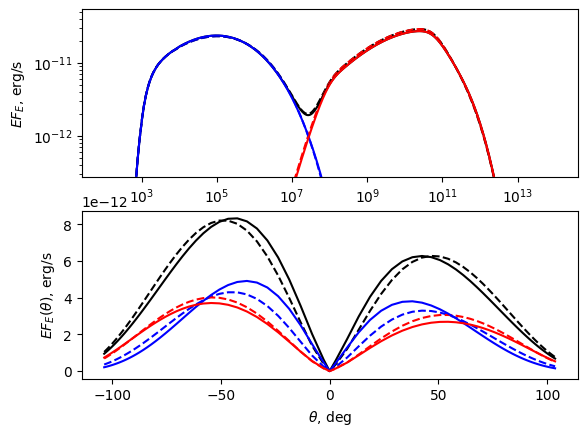

In [9]:
from ibsen.spec import SpectrumIBS
from ibsen.utils import trapz_loglog
from scipy.optimize import curve_fit
fix, ax = plt.subplots(nrows = 2, ncols = 1)

for method in ('simple', 'full'):
    ls = '-' if method == 'full' else '--'
    spec = SpectrumIBS(sys_name=sys_name, 
                       els=els, # els:ElectronsOnIBS class. Mandatory
                       mechanisms = ['ic', 'syn'], # what nontermal mechanisms to use
                       ic_ani = True, # whether to calculate IC as anisotropic. Default False
                       method=method,
                       delta_power=3, # The power p_delta (see above). Default is 3.
                       lorentz_boost=True, # Whether to perform Lorentz boost B, u_g, and n(s, E). Default is True.
                                                             
                       abs_photoel=True, # Whether to include the TBabs-like photoelectric absorbtion. Default is False.
                       nh_tbabs=0.8, # If abs_photoel=True, this is the N_H (in units of 10^22) to use. Default is 0.8. 
                       abs_gg=True, # Whether to include the gamma-gamma absorbtion. Default False.
                       
                       distance = None # The distance to the system [cm]. Default is None. It will try to get the distance from the 
                                       # parameters.
                      )
    
    
    E_ = np.logspace(2, 14, 500) 
    (e_ph_here, # the grid of photon energies. It should be = E_, but I'm not sure hahhaaaa
     sed_here, # the total SED from IBS: 1-d array of length len(e_ph_here)
     sed_s_here # the SED from each point on IBS. 2-d array of shape (len(ibs.s), len(e_ph_here))
    ) = spec.calculate(to_return=True, # If to return SED. Default is False
                       e_ph = E_ # On which energies to calculate the spectrum. Default is np.logspace(2, 14, 1000).
                        )
    
    # you can just do: spec.peek()
    #### Calculate the index of the spectrum in Swift energy range. 
    #### To avoid effects of absorbtion, perform fitting over (3, 10) keV.
    G_ind_swift = spec.index(e1 = 3e3, e2 = 1e4)
    print(G_ind_swift)
    ###########################################################
    emissiv_s = trapz_loglog(spec.sed_s/e_ph_here, e_ph_here, axis=1) # The total flux from the point on IBS
    emissiv_s_sy = trapz_loglog(spec.sed_s_sy/e_ph_here, e_ph_here, axis=1)
    emissiv_s_ic = trapz_loglog(spec.sed_s_ic/e_ph_here, e_ph_here, axis=1)
    
    
    ########### Calculate fluxes in keV and TeV ranges.
    fl_swift, fl_hess = spec.fluxes( bands = (
                                              [3e2, 1e4],
                                              [4e11, 1e14]
                                             )
                                   )
    print('Swift 0.3-10 keV flux is', fl_swift)
    print('H.E.S.S. 0.4-100 TeV flux is', fl_hess)

    ax[0].plot(spec.e_ph, spec.sed, color='k', ls=ls)
    ax[0].plot(spec.e_ph, spec.sed_sy, color='b', ls=ls)
    ax[0].plot(spec.e_ph, spec.sed_ic, color='r', ls=ls)
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    sed_good = np.isfinite(sed_here)
    ax[0].set_ylim(np.nanmax(sed_here[sed_good])/1e2,
                   np.nanmax(sed_here[sed_good])*2)
    ax[0].set_ylabel(r'$EF_E$, erg/s')
    ax[0].set_xlabel(r'$E$, eV')
    
    
    ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s, color='k', ls=ls)
    ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s_sy, color='b', ls=ls)
    ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s_ic, color='r', ls=ls)
    
    ax[1].set_ylabel(r'$EF_E(\theta)$, erg/s')
    ax[1].set_xlabel(r'$\theta$, deg')



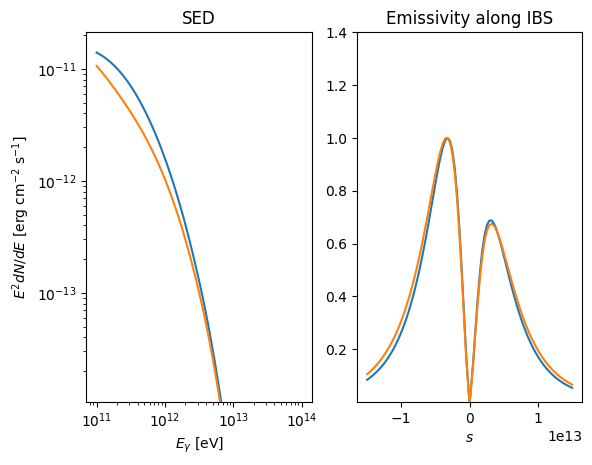

In [8]:
### compare spectra without and with gg-absorbtion
fig, ax = plt.subplots(ncols=2)
for abs_gg in (False, True):
    spec = SpectrumIBS(sys_name=sys_name, mechanisms=('ic', ),
                   els=els,
                   method='simple', 
                   abs_gg=abs_gg, 
                  )
    E = np.geomspace(1e11, 1e14, 100)
    spec.calculate(E)
    spec.peek(ax=ax, show_many=False)